<a href="https://colab.research.google.com/github/leonardo0598/ProgettoLeonardoScandino/blob/main/FIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

# Impostare il dispositivo (usa la GPU se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Image.MAX_IMAGE_PIXELS = None # Or a higher value
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))  ## ResNet usa input 224x224
    # Convert the image to RGB format if it has an alpha channel
    if img.mode == 'RGBA':
        img = img.convert('RGB')  # Remove the alpha channel
    return img


# Definire le trasformazioni per le immagini di train/test/val
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione ImageNet
])

# Percorso alle directory del dataset
data_dir = '/content/drive/MyDrive/FIRE/the_wildfire_dataset_2n_version/'  # Assumendo che il dataset si trovi nella cartella FIRE/dataset

# Caricare il dataset di train, test e validazione usando ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                   loader=process_image,  # Use custom loader
                                   transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                    loader=process_image,
                                    transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                   loader=process_image,
                                   transform=transform)

# Creare i DataLoader per ciascun dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Caricare il modello ResNet18 pre-addestrato
model = models.resnet18(pretrained=True)

# Modificare l'ultimo layer della rete (fully connected) per adattarlo a 2 classi
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classi: "fire" e "no fire"

# Spostare il modello sulla GPU (se disponibile)
model = model.to(device)

# Definire la funzione di loss e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
import torch
import os

# Crea una directory per salvare i modelli
save_dir = "/content/drive/MyDrive/FIRE/models"
os.makedirs(save_dir, exist_ok=True)

# Funzione per il training
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    best_train_acc = 0.0  # Inizializza la migliore accuratezza su train
    best_val_acc = 0.0  # Inizializza la migliore accuratezza su validazione
    best_model_wts = None  # Inizializza i pesi del miglior modello

    for epoch in range(epochs):
        model.train()  # Imposta il modello in modalità training
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterare sui batch del dataset di training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Azzerare i gradienti
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass e aggiornamento dei pesi
            loss.backward()
            optimizer.step()

            # Statistiche
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validazione ad ogni epoca
        val_acc = validate_model(model, val_loader)

        # Salvare il miglior modello basato sull'accuratezza di train e validazione
        if train_acc > best_train_acc and val_acc > best_val_acc:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_model_wts = model.state_dict()  # Salva i pesi del miglior modello
            torch.save(best_model_wts, os.path.join(save_dir, 'best_model.pth'))
            print(f"New best model saved with Train Accuracy: {best_train_acc:.2f}% and Validation Accuracy: {best_val_acc:.2f}%")

    # Salva il modello dell'ultima epoca
    torch.save(model.state_dict(), os.path.join(save_dir, 'last_model.pth'))
    print("Last model saved.")

    # Se vuoi, puoi anche ritornare i pesi migliori alla fine dell'allenamento
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model


In [33]:
# Funzione per la validazione (aggiornata per ritornare l'accuratezza)
def validate_model(model, val_loader):
    model.eval()  # Imposta il modello in modalità valutazione
    correct = 0
    total = 0

    with torch.no_grad():  # Disattivare il calcolo del gradiente
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")
    return val_acc


In [34]:
# Addestramento del modello per 30 epoche
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=13)

Epoch 1/13 - Loss: 0.5309, Train Accuracy: 79.32%
Validation Accuracy: 72.64%
New best model saved with Train Accuracy: 79.32% and Validation Accuracy: 72.64%
Epoch 2/13 - Loss: 0.2496, Train Accuracy: 89.38%
Validation Accuracy: 87.06%
New best model saved with Train Accuracy: 89.38% and Validation Accuracy: 87.06%
Epoch 3/13 - Loss: 0.1995, Train Accuracy: 94.01%
Validation Accuracy: 70.40%
Epoch 4/13 - Loss: 0.1659, Train Accuracy: 94.92%
Validation Accuracy: 75.12%
Epoch 5/13 - Loss: 0.1141, Train Accuracy: 96.16%
Validation Accuracy: 86.32%
Epoch 6/13 - Loss: 0.0693, Train Accuracy: 97.74%
Validation Accuracy: 85.82%
Epoch 7/13 - Loss: 0.1676, Train Accuracy: 93.33%
Validation Accuracy: 67.41%
Epoch 8/13 - Loss: 0.1101, Train Accuracy: 96.38%
Validation Accuracy: 85.82%
Epoch 9/13 - Loss: 0.0946, Train Accuracy: 97.06%
Validation Accuracy: 86.07%
Epoch 10/13 - Loss: 0.1128, Train Accuracy: 95.71%
Validation Accuracy: 82.59%
Epoch 11/13 - Loss: 0.0518, Train Accuracy: 98.42%
Valida

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
import torch

# Funzione per testare il modello su test dataset
def test_model(model, test_loader, model_path):
    # Carica i pesi del miglior modello
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Imposta il modello in modalità valutazione
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")


In [36]:

# Testare il modello addestrato
test_model(model, test_loader, os.path.join(save_dir, 'best_model.pth'))

<ipython-input-35-c7f966dc19ec>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 91.11%


In [45]:
def test_random_images(model, image_folder, num_images=5):
    model.eval()  # Imposta il modello in modalità valutazione

    # Trasformazioni da applicare alle immagini
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize a 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione
    ])

    # Recupera tutte le immagini dalla cartella
    all_images = [img for img in os.listdir(image_folder) if img.endswith(('png', 'jpg', 'jpeg'))]

    # Seleziona immagini casuali
    random_images = random.sample(all_images, min(num_images, len(all_images)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert('RGB')  # Apri l'immagine
        img_tensor = transform(img).unsqueeze(0).to(device)  # Applica le trasformazioni e aggiungi la dimensione batch

        # Esegui la previsione
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)

        # Visualizza l'immagine e la previsione
        axes[i].imshow(img)
        axes[i].set_title(f'{"No Fire" if predicted.item() == 1 else "Fire"}')
        axes[i].axis('off')

    plt.show()


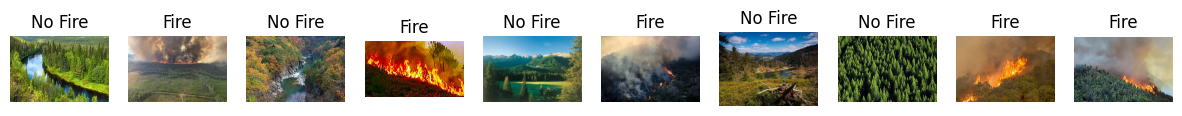

In [46]:
# Esegui il test su immagini casuali
image_folder = '/content/drive/MyDrive/FIRE/the_wildfire_dataset_2n_version/TEST_RANDOM'  # Sostituisci con il tuo percorso
test_random_images(model, image_folder, num_images=10)  # Scegli il numero di immagini da testare
